In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(base)
from plotting_functions import plot_across_subjects
from trained_results_funcs import find_best_layer, find_best_sigma
from untrained_results_funcs import compute_p_val
import pandas as pd
import seaborn as sns
from scipy.stats import false_discovery_control

In [100]:
np.load('/data/LLMs/brainscore/results_pereira//shuffled/y_test_ordered_384.npy').shape

(384, 92540)

In [101]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()

subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
non_nan_indices_243 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_243.npy") # voxels which are in 243
non_nan_indices_384 = np.load(f"{data_processed_folder_pereira}/non_nan_indices_384.npy") # voxels which are in 384

In [102]:
resultsPath = '/data/LLMs/brainscore/'
ytest_243 = np.load(f'{resultsPath}results_pereira/y_test_ordered_243.npy')
ytest_384 = np.load(f'{resultsPath}results_pereira/y_test_ordered_384.npy')
ytest_243_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/y_test_ordered_243.npy')
ytest_384_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/y_test_ordered_384.npy')
mse_intercept_243 = np.load(f'{resultsPath}results_pereira/mse_intercept_243.npy')
mse_intercept_384 = np.load(f'{resultsPath}results_pereira/mse_intercept_384.npy')
mse_intercept_243_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/mse_intercept_243.npy')
mse_intercept_384_shuffled = np.load(f'{resultsPath}results_pereira/shuffled/mse_intercept_384.npy')
ytest_fed = np.load(f"{resultsPath}results_fedorenko/y_test_ordered.npy")
ytest_blank = np.load(f"{resultsPath}results_blank/y_test_ordered.npy")

In [103]:
shape_pereira_full = (627, int(subjects_arr_pereira.shape[0]))

ytest_pereira = np.full(shape_pereira_full, fill_value=np.nan)
ytest_pereira[:243, non_nan_indices_243] = ytest_243
ytest_pereira[243:, non_nan_indices_384] = ytest_384

ytest_pereira_shuffled  = np.full(shape_pereira_full, fill_value=np.nan)
ytest_pereira_shuffled [:243, non_nan_indices_243] = ytest_243_shuffled 
ytest_pereira_shuffled [243:, non_nan_indices_384] = ytest_384_shuffled 

mse_intercept_pereira_full = np.full(shape_pereira_full, fill_value=np.nan)
mse_intercept_pereira_full[:243, non_nan_indices_243] = mse_intercept_243
mse_intercept_pereira_full[243:, non_nan_indices_384] = mse_intercept_384

mse_intercept_pereira_full_shuffled = np.full(shape_pereira_full, fill_value=np.nan)
mse_intercept_pereira_full_shuffled[:243, non_nan_indices_243] = mse_intercept_243_shuffled
mse_intercept_pereira_full_shuffled[243:, non_nan_indices_384] = mse_intercept_384_shuffled

In [104]:
noL2_str = ''
resultsPath_pereira = f"{resultsPath}results_pereira/"
perf = 'out_of_sample_r2'
dataset = 'pereira'
feature_extraction_methods = ['', '-sp', '-mp']
shuffled_arr = [True, False]


results_dict = {'Model': [], 'shuffled': [], 'Network': [], 'subjects': [], 'perf': []}

for shuffle in shuffled_arr:
    
    if shuffle:
        resultsPath_loop = f"{resultsPath_pereira}shuffled/"
        shuffle_str = 'shuffled'
    else:
        resultsPath_loop = resultsPath_pereira
        shuffle_str = 'contig'
    
    for fe in feature_extraction_methods:
    
        best_results = np.full(shape_pereira_full, fill_value=np.nan)
            
        for network in np.unique(networks_arr_pereira):
    
            network_indices_384 = np.argwhere(br_labels_dict['384'] == network).squeeze()
            network_indices_243 = np.argwhere(br_labels_dict['243'] == network).squeeze()
                
            gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                        resultsPath=resultsPath_loop, selected_network_indices=network_indices_384, dataset=dataset, 
                                                        subjects=subjects_dict['384'], perf=perf, feature_extraction=fe)
            gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                        resultsPath=resultsPath_loop, selected_network_indices=network_indices_243, dataset=dataset, 
                                                        subjects=subjects_dict['243'], perf=perf, feature_extraction=fe)

            results_dict['perf'].extend(gpt2_xl_384_bl_perf[network_indices_384])
            results_dict['perf'].extend(gpt2_xl_243_bl_perf[network_indices_243])
            results_dict['Network'].extend(np.repeat(network, len(network_indices_384)))
            results_dict['Network'].extend(np.repeat(network, len(network_indices_243)))
            results_dict['subjects'].extend(subjects_dict['384'][network_indices_384])
            results_dict['subjects'].extend(subjects_dict['243'][network_indices_243])
            results_dict['Model'].extend(np.repeat(f'GPT2-XL{fe}', len(network_indices_384)))
            results_dict['Model'].extend(np.repeat(f'GPT2-XL{fe}', len(network_indices_243)))
            results_dict['shuffled'].extend(np.repeat(shuffle_str, len(network_indices_384)))
            results_dict['shuffled'].extend(np.repeat(shuffle_str, len(network_indices_243)))
            
            
results_dict_pd = pd.DataFrame(results_dict)
results_dict_pd.head()

,Model,shuffled,Network,subjects,perf
0,GPT2-XL,shuffled,DMN,018,0.160707
1,GPT2-XL,shuffled,DMN,018,0.233068
2,GPT2-XL,shuffled,DMN,018,0.186691
3,GPT2-XL,shuffled,DMN,018,0.224480
4,GPT2-XL,shuffled,DMN,018,0.190902


/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_3372966/2137172233.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)


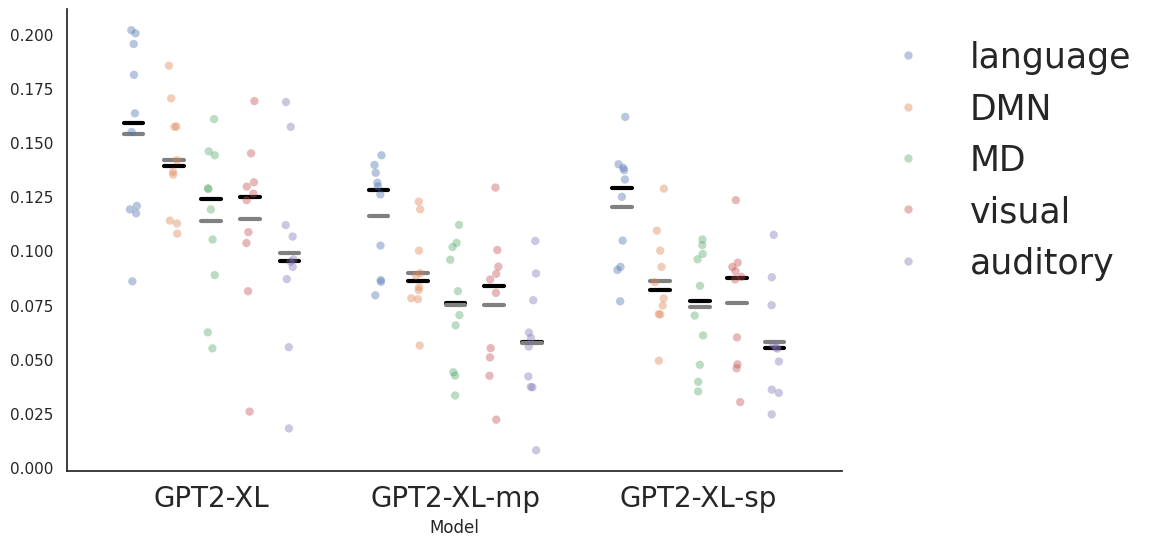

/home2/ebrahim/miniconda3/envs/llm_brain/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_3372966/2137172233.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)


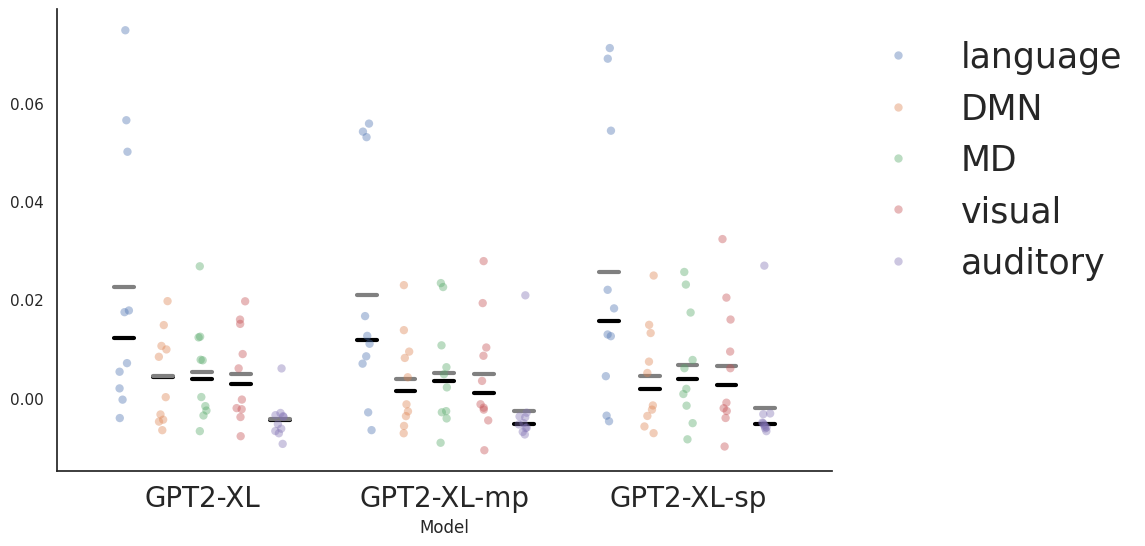

In [105]:
for shuffle in results_dict_pd.shuffled.unique():
    results_dict_pd_s = results_dict_pd.loc[results_dict_pd.shuffled==shuffle]
    results_dict_pd_s = results_dict_pd_s.drop(axis=1, labels='shuffled')
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    if shuffle == 'contig':
        yticks = None
    else:
        yticks = None
    subject_avg_pd, dict_pd_merged, dict_pd_with_all = plot_across_subjects(results_dict_pd_s, None, dataset='pereira', selected_networks=np.unique(networks_arr_pereira), ax_select=ax,clip_zero=False, plot_legend=True, 
                                                                            ylabel=False, x_var='Model', hue_var='Network', hue_order=['language', 'DMN', 'MD', 'visual', 'auditory'], line_extend=0.04, plot_xlabel=True, yticks=yticks)
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    plt.show()



In [135]:
noL2_str = ''
resultsPath_pereira = f"{resultsPath}results_pereira/"
perf = 'out_of_sample_r2'
fe = ''
dataset = 'pereira'

feature_extraction_methods = ['']
mse_best_layer = {}

for shuffle in shuffled_arr:
    
    if shuffle:
        resultsPath_loop = f"{resultsPath_pereira}shuffled/"
        shuffle_str = 'shuffled'
        y_test_loop = ytest_pereira_shuffled
        ytest_384_loop = ytest_384_shuffled
        ytest_243_loop = ytest_243_shuffled
    else:
        resultsPath_loop = resultsPath_pereira
        shuffle_str = 'contig'
        y_test_loop = ytest_pereira
        ytest_384_loop = ytest_384
        ytest_243_loop = ytest_243
        
    print(resultsPath_loop)
        
    for fe in feature_extraction_methods:
        
        y_hat_full = np.full(shape_pereira_full, fill_value=np.nan)

        gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_384', 
                                                            resultsPath=resultsPath_loop, selected_network_indices=network_indices_384, dataset=dataset, 
                                                            subjects=subjects_dict['384'], perf=perf, feature_extraction=fe)
        gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer(np.arange(0,49), noL2_str=noL2_str, exp='_243', 
                                                    resultsPath=resultsPath_loop, selected_network_indices=network_indices_243, dataset=dataset, 
                                                    subjects=subjects_dict['243'], perf=perf, feature_extraction=fe)
        
        
        best_layer_384 = max(gpt2_xl_384_dict, key=gpt2_xl_384_dict.get)
        best_layer_243 = max(gpt2_xl_243_dict, key=gpt2_xl_243_dict.get)
        
        y_hat_384 = np.load(f"{resultsPath_loop}pereira_gpt2-xl{fe}_layer_{best_layer_384}_1_384.npz")['y_hat']
        y_hat_243 = np.load(f"{resultsPath_loop}pereira_gpt2-xl{fe}_layer_{best_layer_243}_1_243.npz")['y_hat']
        
        mse_384 = (ytest_384_loop - y_hat_384)**2
        mse_243 = (ytest_243_loop - y_hat_243)**2
        
        ##y_hat_full[:243, non_nan_indices_243] = y_hat_243
        #y_hat_full[243:, non_nan_indices_384] = y_hat_384
        
        mse_best_layer[f"{shuffle_str}_{fe}_384"] = mse_384
        mse_best_layer[f"{shuffle_str}_{fe}_243"] = mse_243

/data/LLMs/brainscore/results_pereira/shuffled/
/data/LLMs/brainscore/results_pereira/


In [138]:
mse_best_layer.keys()

dict_keys(['shuffled__384', 'shuffled__243', 'contig__384', 'contig__243'])

In [139]:
np.mean(mse_best_layer['shuffled__384'])

1.6797441

In [140]:
np.mean(mse_best_layer['contig__384'])

1.9466487

In [149]:
store_subject_network_idxs_384 = {}
store_subject_network_idxs_243 = {}
mse_subject_network_best_layer = {}
mse_subject_network_intercept = {}

from scipy.stats import ttest_rel

pvalues_pereira = {'fe': [], 'network': [], 'subject': [], 'pval': [], 'pval_orig': [], 'shuffled': []}

for shuffle in shuffled_arr:
    
    if shuffle:
        shuffle_str = 'shuffled'
        mse_intercept_243_loop = mse_intercept_243_shuffled
        mse_intercept_384_loop = mse_intercept_384_shuffled
        
    else:
        shuffle_str = 'contig'
        mse_intercept_243_loop = mse_intercept_243
        mse_intercept_384_loop = mse_intercept_384
    
    for fe in feature_extraction_methods:
        
        for e in exp:

            mse_best_layer_fe = mse_best_layer[f"{shuffle_str}_{fe}_{e}"]
            
            if e == '384':
                mse_intercept_loop = mse_intercept_384_loop
            else:
                mse_intercept_loop = mse_intercept_243_loop
                

            for network in np.unique(bre):
                
                for subject in np.unique(subjects_arr_pereira):
                    
                    print(fe, network, subject)
                    
                    #subject_idxs = np.argwhere(subjects_arr_pereira==subject)
                    #network_idxs = np.argwhere(networks_arr_pereira==network)
                    #subject_network_idxs =  list(np.intersect1d(subject_idxs, network_idxs))
                    subject_idxs = np.argwhere(subjects_dict[e]==subject)
                    network_idxs = np.argwhere(br_labels_dict[e]==network)
                    subject_network_idxs =  list(np.intersect1d(subject_idxs, network_idxs))
                    
                    # do a t-test between the intercept only model and the 
                    stat, pval = ttest_rel(mse_best_layer_fe[:, subject_network_idxs], mse_intercept_loop[:, subject_network_idxs], axis=0, nan_policy='omit', alternative='less')

                    
                    pval = pval[~np.isnan(pval)]
                    
                    pval_fdr = false_discovery_control(pval, method='bh')
                    
                    pvalues_pereira['pval'].extend(pval_fdr)
                    pvalues_pereira['pval_orig'].extend(pval)
                    pvalues_pereira['subject'].extend(np.repeat(subject,len(pval)))
                    pvalues_pereira['network'].extend(np.repeat(network,len(pval)))
                    pvalues_pereira['shuffled'].extend(np.repeat(shuffle_str,len(pval)))
                    
                    
                    
                    if len(fe) == 0:
                        fe_name = '-lt'
                    else:
                        fe_name = fe
                        
                    pvalues_pereira['fe'].extend(np.repeat(fe_name,len(pval)))
                    
                    
pvalues_pereira = pd.DataFrame(pvalues_pereira)

 DMN 018
 DMN 199
 DMN 215
 DMN 288
 DMN 289
 DMN 296
 DMN 343
 DMN 366
 DMN 407
 DMN 426
 MD 018
 MD 199
 MD 215
 MD 288
 MD 289
 MD 296
 MD 343
 MD 366
 MD 407
 MD 426
 auditory 018
 auditory 199
 auditory 215
 auditory 288
 auditory 289
 auditory 296
 auditory 343
 auditory 366
 auditory 407
 auditory 426
 language 018
 language 199
 language 215
 language 288
 language 289
 language 296
 language 343
 language 366
 language 407
 language 426
 visual 018
 visual 199
 visual 215
 visual 288
 visual 289
 visual 296
 visual 343
 visual 366
 visual 407
 visual 426
 DMN 018
 DMN 199
 DMN 215
 DMN 288
 DMN 289
 DMN 296
 DMN 343
 DMN 366
 DMN 407
 DMN 426
 MD 018
 MD 199
 MD 215
 MD 288
 MD 289
 MD 296
 MD 343
 MD 366
 MD 407
 MD 426
 auditory 018
 auditory 199
 auditory 215
 auditory 288
 auditory 289
 auditory 296
 auditory 343
 auditory 366
 auditory 407
 auditory 426
 language 018
 language 199
 language 215
 language 288
 language 289
 language 296
 language 343
 language 366
 languag

network
DMN         0.811460
MD          0.681458
auditory    0.564802
language    0.811136
visual      0.719530
Name: pval, dtype: float64


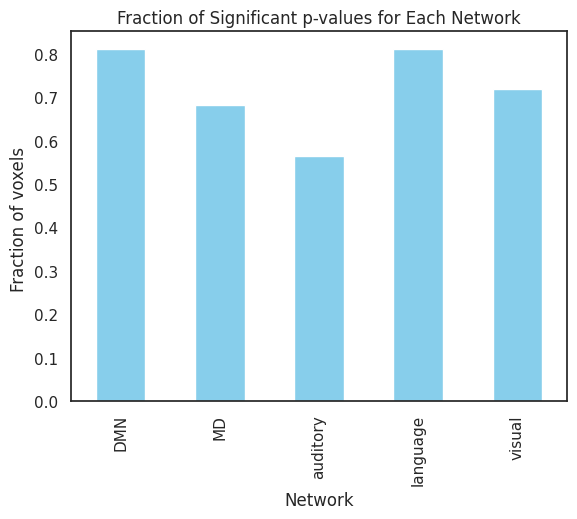

network
DMN         0.842121
MD          0.749938
auditory    0.647669
language    0.842424
visual      0.768803
Name: pval_orig, dtype: float64


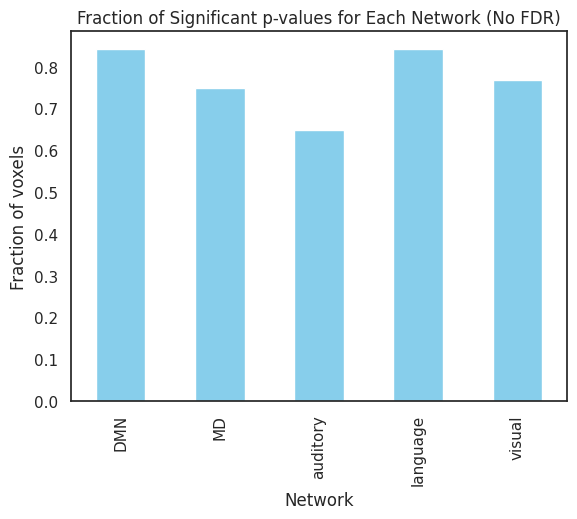

network
DMN         0.022371
MD          0.034442
auditory    0.000000
language    0.158023
visual      0.016266
Name: pval, dtype: float64


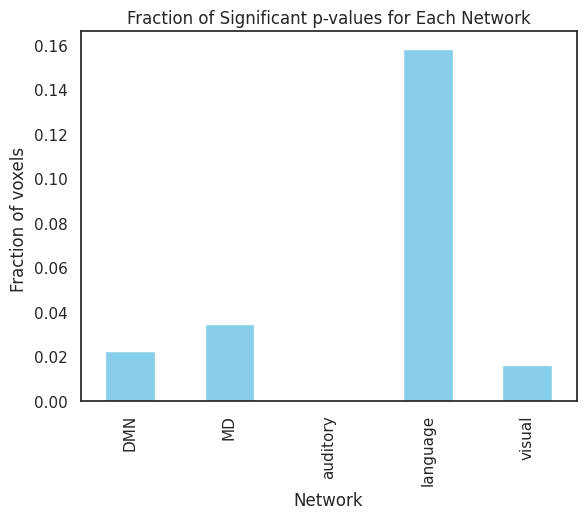

network
DMN         0.104663
MD          0.106046
auditory    0.011538
language    0.258528
visual      0.095862
Name: pval_orig, dtype: float64


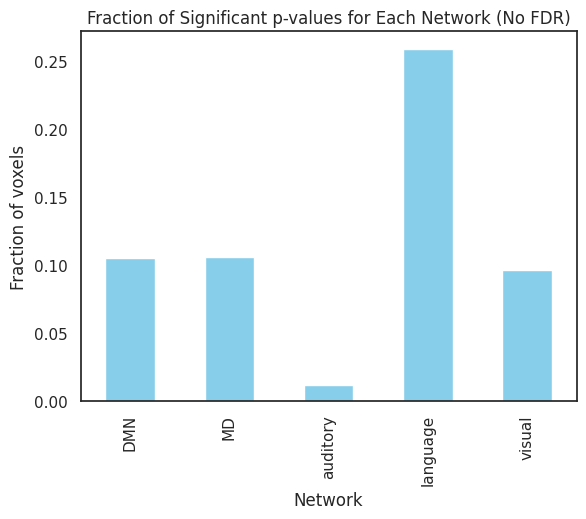

In [151]:
shuffled_str_arr = ['shuffled', 'contig']
for shuffle_str in shuffled_str_arr:
    
    pvalues_pereira_loop = pvalues_pereira.loc[pvalues_pereira.shuffled==shuffle_str]
    
    # Group by 'network' and calculate fraction of p-values under 0.05
    fraction_under_005_fdr = pvalues_pereira_loop.groupby('network')['pval'].apply(lambda x: (x < 0.05).mean())
    
    print(fraction_under_005_fdr)

    # Plot
    fraction_under_005_fdr.plot(kind='bar', color='skyblue')
    plt.ylabel("Fraction of voxels ")
    plt.xlabel("Network")
    plt.title("Fraction of Significant p-values for Each Network")
    plt.show()

    # Group by 'network' and calculate fraction of p-values under 0.05
    fraction_under_005 = pvalues_pereira_loop.groupby('network')['pval_orig'].apply(lambda x: (x < 0.05).mean())
    
    print(fraction_under_005)

    # Plot
    fraction_under_005.plot(kind='bar', color='skyblue')
    plt.ylabel("Fraction of voxels")
    plt.xlabel("Network")
    plt.title("Fraction of Significant p-values for Each Network (No FDR)")
    plt.show()


In [91]:

for key in mse_subject_network_best_layer.keys():
    
    
stat, p = ttest_rel(mse_subject_network_best_layer['018_DMN_'], mse_subject_network_intercept['018_DMN'], axis=0, nan_policy='omit')

In [97]:
# Example arrays with NaN values
a = np.array([1.2, 2.3, np.nan, 4.5, 5.6])
b = np.array([1.0, np.nan, 3.4, 4.6, 5.5])

# Perform paired t-test while ignoring NaN pairs
t_stat, p_val = ttest_rel(a, b, nan_policy="omit")

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Example arrays with NaN values
a = np.array([1.2, 4.5, 5.6])
b = np.array([1.0, 4.6, 5.5])

# Perform paired t-test while ignoring NaN pairs
t_stat, p_val = ttest_rel(a, b, nan_policy="omit")

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 0.7559289460184556
p-value: 0.5285954792089678
t-statistic: 0.7559289460184556
p-value: 0.5285954792089678
